## ВКР: обработка данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

#### Зачем этот ноутбук?

В `scraping.ipynb` были собраны и подготовлены данные. Возможно, стоит еще доработать (в разделе "пост-обработка"):
- Словарь образования
- Справочник по интересам
- Аналитические комбинации слов

Стоит убрать раздел "Черновик" оттуда и перенести сюда основные результаты.

Что сделать в ближайшее время?

1. Сегментацию разными правилами

2. Разметить текст и построить скоринговую (классификационную) модель

Для начала — разбиение на термы, оно было в Черновике.

### Библиотеки

selenium поскольку нужен js

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

### Далее

Разметим первые 100 резюме:

In [5]:
df = pd.read_csv('backup/16.11/resumes_features.csv')
df.head(100)

,Unnamed: 0,Unnamed: 0.1,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,...,Кол-во образований,Работа 1,Работа 2,Топовость образования,is_eng?,Справочник по интересам,Навыки списком,Релокация?,Коммандировка?,Город?
0,0,0,https://hh.ru/resume/1aa91e410000fd3cda0039ed1...,Analyst,"Moscow, willing to relocate, prepared for occa...",Work experience 7 years 4 months,"Responsible, communicable, quick study and det...",Higher education\n2015\nMOSCOW STATE UNIVERSIT...,"Specializations:\nSales manager, account manag...",Поддержка продаж / владение ПО для поддержки п...,...,1,"NUTRICIA\nMoscow, nutricia.ru\nFood Products.....","Volkswagen Group Russia\nMoscow, www.volkswage...",False,ENG,---,['Поддержка продаж / владение ПО для поддержки...,prepared for occasional business trips,willing to relocate,Moscow
1,1,1,https://hh.ru/resume/628596ac000657935b0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к редким ...",Опыт работы 1 год 5 месяцев,В последние годы проходила обучение без возмож...,Высшее образование (Бакалавр)\n2022\nНациональ...,"Специализации:\nBI-аналитик, аналитик данных\n...","Работа с компьютерными программами, программы ...",...,1,"Ozon\nМладший аналитик\nСоздание, поддержка и ...",OZON\nСтажер группы BI аналитики и отчетности\...,True,RU,found smt by rule (Analyst)|(Аналитик данных)|...,"['Работа с компьютерными программами, программ...",готова к редким командировкам,не готова к переезду,Москва
2,2,2,https://hh.ru/resume/dfbcae000004342d8f0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к команди...",Опыт работы 3 года 3 месяца,---,Высшее образование (Бакалавр)\n2019\nСамарский...,"Специализации:\nАналитик\nBI-аналитик, аналити...",Другое\nPython\nSQL\nУмение работать в коллект...,...,1,"Банк ВТБ (ПАО)\nМосква, www.vtbcareer.com\nФин...",---,False,RU,found smt by rule (Analyst)|(Аналитик данных)|...,"['Другое', 'Python', 'SQL', 'Умение работать в...",готова к командировкам,не готова к переезду,Москва
3,3,3,https://hh.ru/resume/bebf6a630008069d8c0039ed1...,Аналитик,"Санкт-Петербург, м. Гражданский проспект, гото...",Опыт работы 7 лет 2 месяца,Имею экономическое образование. Продвинутый по...,Высшее образование (Бакалавр)\n2015\nСанкт-Пет...,Специализации:\nАналитик\nЗанятость: полная за...,"Работа с компьютерными программами, программы ...",...,1,A&D Mortgage\nСтарший BI аналитик\nСоздание Po...,"Сбер\nСанкт-Петербург, rabota.sber.ru/\nФинанс...",False,RU,found smt by rule (Analyst)|(Аналитик данных)|...,"['Работа с компьютерными программами, программ...",готов к командировкам,готов к переезду,Санкт
4,4,4,https://hh.ru/resume/8606f37b000773de980039ed1...,Программист-разработчик,"Москва, м. Петровско-Разумовская, не готов к п...",Опыт работы 1 год 1 месяц,Имеется опыт в создании Android-приложений на ...,Высшее образование (Бакалавр)\n2022\nЧелябинск...,"Специализации:\nПрограммист, разработчик\nЗаня...",Применение стека технологий/Цифровые навыки\nL...,...,1,MoneyCare\nBI-аналитик\nРабота с big data(Pyth...,---,False,ENG,---,['Применение стека технологий/Цифровые навыки'...,не готов к командировкам,не готов к переезду,Москва
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,95,https://hh.ru/resume/ff6db1a000005dc60b0039ed1...,Analyst,"Moscow, metro station Kantemirovskaya, willing...",Work experience 14 years 3 months,Hardworking and well-organized specialist with...,Higher education\n2022\nЯндекс Практикум\nИнже...,"Specializations:\nTester\nSales manager, accou...","Управление отношениями с клиентами, деловая ко...",...,3,"John Deere Agricultural Holdings, Inc.\nwww.jo...",---,False,ENG,found smt by rule (Analyst)|(Аналитик данных)|...,"['Управление отношениями с клиентами, деловая ...",prepared for occasional business trips,willing to relocate,Moscow
96,96,96,https://hh.ru/resume/4a19a20e0002b43ffe0039ed1...,Аналитик-маркетолог,"Москва, м. Раменки, не готова к переезду, гото...",Опыт работы 3 года 7 месяцев,"Ответственна к выполн

Сделаю это в икселе в отдельном файле

**Итак, текст размечен для классификации. Теперь сегментация по "О себе".**

Токенизация раздела "О себе" на 1-граммы:

In [6]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе'])

for col_ind in df2.index:
    col = df2.iloc[col_ind]['О себе']
    if col:
        df2.iloc[col_ind]['О себе'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

In [10]:
df2.sample(3)

,О себе
13016,"[хобби, горный, лыжа, путешествие]"
1293,None
17146,"[пк, опытный, пользователь, word, excel, power..."


^ Стоп-слова убраны, все в нормальной форме => их не будет и дальше.

На 2-граммы:

In [11]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [14]:
df2.sample(3)

,О себе,О себе 2
14524,"[окончить, средний, высокий, образование, г, т...","[окончить средний, средний высокий, высокий об..."
9115,"[высокий, организаторский, способность, умение...","[высокий организаторский, организаторский спос..."
10757,"[универсальный, ориентировать, результат, проф...","[универсальный ориентировать, ориентировать ре..."


На 3-граммы:

In [15]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [17]:
df2.sample(3)

,О себе,О себе 2,О себе 3
11035,"[браться, дело, довести, конец, учиться, регул...","[браться дело, дело довести, довести конец, ко...","[браться дело довести, дело довести конец, дов..."
1276,"[financial, professional, with, solid, experie...","[financial professional, professional with, wi...","[financial professional with, professional wit..."
363,"[https, t, me, antoin, antoinea, gmail, com, с...","[https t, t me, me antoin, antoin antoinea, an...","[https t me, t me antoin, me antoin antoinea, ..."


Строим эмбеддинги:

In [19]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавились от пропусков:

In [28]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

In [29]:
df2[df2['О себе 3'].isna()]['О себе 3']

Series([], Name: О себе 3, dtype: object)

In [30]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [31]:
model = Word2Vec.load("word2vec.model")

In [32]:
model

In [33]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(956001, 956134)

^ наверное лучше еще привести все токены в тексте к норм. форме?

In [37]:
df2['О себе 3']

0        [responsible communicable quick, communicable ...
1        [последний год проходить, год проходить обучен...
2                                                        -
3        [иметь экономический образование, экономически...
4        [иметься опыт создание, опыт создание android,...
                               ...                        
19813    [высокий работоспособность вдумчивость, работо...
19814    [увлекаться спорт вредный, спорт вредный привы...
19815    [уверенный пользователь пк, пользователь пк ра...
19816    [абсолютно честный очень, честный очень ответс...
19817    [i общий подготовленность, общий подготовленно...
Name: О себе 3, Length: 19818, dtype: object

In [38]:
vector = model.wv['последний год проходить']  # get numpy vector of a word
sims = model.wv.most_similar('последний год проходить', topn=10)  # get other similar words

In [39]:
sims

[('обучение возможность работать', 0.9961813688278198),
 ('проходить обучение возможность', 0.9958987832069397),
 ('год проходить обучение', 0.9893797039985657),
 ('возможность работать проходить', 0.9098530411720276),
 ('возможность работать заниматься', 0.8871986865997314),
 ('проходить обучение университет', 0.8798285722732544),
 ('год проходить служба', 0.8525605797767639),
 ('возможность работать специальность', 0.8487045764923096),
 ('трудолюбивый последний год', 0.8085861802101135),
 ('возможность работать последний', 0.8063167929649353)]

In [41]:
vector

array([-0.37307343, -0.07364435, -0.3265382 , -0.23713824, -0.18907309,
       -0.0453213 , -0.01557316, -0.07271679,  0.25192723,  0.08571105,
       -0.61602664,  0.09095799,  0.3136586 , -0.26724374, -0.12161044,
       -0.37763467, -0.14548205, -0.05734489, -0.2080641 , -0.00200169,
        0.28758132,  0.33093262,  0.05868349, -0.1345159 ,  0.43997163,
       -0.18430804,  0.556874  ,  0.15086077, -0.37714976, -0.14361143,
       -0.05792023,  0.01079078,  0.09002791, -0.3577086 ,  0.02779617,
        0.098566  , -0.26183906,  0.12866214,  0.01644875, -0.00222085,
       -0.11270764,  0.3384831 , -0.1190339 , -0.4718238 , -0.16508017,
       -0.10490161,  0.03208315, -0.13031693,  0.08853833, -0.23310784,
        0.64590156, -0.365463  , -0.22905467, -0.00899316, -0.01978675,
        0.10636646, -0.03191986, -0.3483992 , -0.36999097,  0.03966913,
       -0.09689924,  0.05511505, -0.31348342, -0.13801149, -0.059569  ,
       -0.11890747, -0.60871845,  0.07050871, -0.18404856,  0.46

Итак, мы построили эмбеддинги. Теперь кластеризуем. Для этого сначала строим новую табличку:

In [45]:
model.wv

In [49]:
our_data = pd.DataFrame(df2['О себе 3'])

In [50]:
our_data['emb'] = 0

In [51]:
our_data

,О себе 3,emb
0,"[responsible communicable quick, communicable ...",0
1,"[последний год проходить, год проходить обучен...",0
2,-,0
3,"[иметь экономический образование, экономически...",0
4,"[иметься опыт создание, опыт создание android,...",0
...,...,...
19813,"[высокий работоспособность вдумчивость, работо...",0
19814,"[увлекаться спорт вредный, спорт вредный привы...",0
19815,"[уверенный пользователь пк, пользователь пк ра...",0
19816,"[абсолютно честный очень, честный очень ответс...",0


In [55]:
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)

In [57]:
our_data['emb'] = embs

In [66]:
embs_flattened = []
for x in our_data['emb']:
    x_flat = []
    for z in x:
        x_flat += list(z)
    embs_flattened.append(x_flat)

In [67]:
our_data['flat_emb'] = embs_flattened

In [70]:
our_data['flat_emb'][0]

[0.005212813,
 0.0030616242,
 0.00029113443,
 0.0062126787,
 0.00988482,
 -0.006254855,
 -0.0060405047,
 0.003971643,
 0.00030735318,
 0.005404983,
 0.0016669013,
 -0.0018265814,
 0.0062693716,
 0.008740678,
 -0.0009026522,
 -0.009855515,
 -0.0074177724,
 -0.0010419518,
 0.009047396,
 -0.009739582,
 -0.00947154,
 0.0016750413,
 0.0038169206,
 -0.008117456,
 0.005435146,
 0.0014472967,
 -0.003338907,
 0.0033721246,
 0.009480596,
 0.0015481208,
 0.0012566701,
 -0.005713288,
 -0.0066341683,
 0.007910322,
 -0.0028235056,
 0.00022793913,
 0.0060030967,
 -0.0027415906,
 -0.0080625275,
 0.009686509,
 -0.007143958,
 -0.0035772761,
 -0.0075091976,
 -0.00073114655,
 0.00029159972,
 0.0063789757,
 0.0017356797,
 0.0004590728,
 -0.0017585406,
 0.00074864517,
 -0.0030066345,
 0.006820782,
 0.0053990856,
 -0.0027752074,
 0.0006719272,
 0.0023627842,
 0.0057840636,
 -0.00047638934,
 0.0014236103,
 -0.0072130263,
 0.00631733,
 -0.0035450805,
 -0.006129455,
 0.0014309532,
 -0.008176794,
 0.0017838291,


In [83]:
our_data['flat_emb'].dropna()

0        [0.005212813, 0.0030616242, 0.00029113443, 0.0...
1        [-0.37307343, -0.07364435, -0.3265382, -0.2371...
2        [-0.00053622725, 0.00023643016, 0.0051033497, ...
3        [-0.003922433, -0.0049155187, 0.0038085452, -0...
4        [-0.0061970456, -0.0033560358, 0.0072174342, -...
                               ...                        
19813    [-0.00298449, 0.004879266, -0.0062477007, -0.0...
19814    [-0.0056323255, -0.009578427, 0.0010607364, -0...
19815    [0.60215724, 1.1047537, -0.26125056, 0.0263797...
19816    [-0.00525861, 0.0028346444, 0.004775579, 0.008...
19817    [-7.805753e-05, 0.0035385727, 0.0035489248, 0....
Name: flat_emb, Length: 19818, dtype: object

Кластеризуем:

In [84]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

kmeans = KMeans(
                init="random",
                n_clusters=3,
                n_init=10,
                max_iter=300,
                random_state=42
            )

kmeans.fit(our_data['flat_emb'].dropna())

ValueError: setting an array element with a sequence.

Почитать:

Тоже уменьшить как-то размер ноутбука

### Черновик (раньше был в `scraping.ipynb`)

embeddings:

- tf-idf: важность слов (вектор = мера важности каждого слова в документе через запятую)

- word2vec и BERT: учиытвают семантические особенности

Курс по тектсовой аналитике с Я.Диска + 

https://stepik.org/course/129443/promo пока не смотрел

см еще статьи в папке 7.12

Реализация w2v https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28

lib: https://radimrehurek.com/gensim/models/word2vec.html (потом пойму в чем ограничения)

In [167]:
from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

In [169]:
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:50]

['работа',
 '•',
 'опыт',
 'знание',
 'навык',
 'работать',
 'бизнес',
 'умение',
 'проект',
 'управление',
 'система',
 'разработка',
 'ms',
 'год',
 'компания',
 'команда',
 'продажа',
 'анализ',
 'процесс',
 'результат',
 'качество',
 'решение',
 'пользователь',
 'ответственность',
 'задача',
 'новый',
 'уровень',
 'высокий',
 'язык',
 'дать',
 'аналитический',
 'способность',
 'excel',
 'иметь',
 'office',
 'личный',
 'организация',
 'развитие',
 'человек',
 'программа',
 'финансовый',
 'профессиональный',
 'коммуникабельность',
 'обучение',
 '–',
 'sql',
 'клиент',
 'уметь',
 'microsoft',
 'c']

In [174]:
from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data2.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

In [175]:
df2.sample(3)

,О себе,О себе 2
8772,"[английский, язык, –, средний, уровень, уверен...","[английский язык, язык –, – средний, средний у..."
2891,None,None
4710,"[•, коммуникабельность, ответственность, добро...","[• коммуникабельность, коммуникабельность отве..."


In [176]:
len(word_freq)
sorted(word_freq, key=word_freq.get, reverse=True)[:50]

['опыт работа',
 'умение работать',
 'бизнес процесс',
 'ms office',
 'работать команда',
 'личный качество',
 'склад ум',
 'аналитический склад',
 'уверенный пользователь',
 'пользователь пк',
 'английский язык',
 'word excel',
 'нацеленность результат',
 'больший объём',
 'вредный привычка',
 'microsoft office',
 'управление проект',
 'опытный пользователь',
 'большой опыт',
 'база дать',
 'иметь опыт',
 '• опыт',
 'объём информация',
 'навык работа',
 'ведение переговоры',
 'жизненный позиция',
 'высокий работоспособность',
 'power point',
 'право категория',
 'активный жизненный',
 'высокий уровень',
 'быстрый обучаемость',
 'уметь работать',
 'организаторский способность',
 'поставить задача',
 'информационный система',
 'принимать решение',
 'работать больший',
 'продвинуть пользователь',
 'легко обучать',
 'водительский право',
 'опыт управление',
 '• знание',
 'аналитический способность',
 'office word',
 'ms sql',
 'профессиональный навык',
 'режим многозадачность',
 'программ

**хм t-SNE**:

сделаю как тут https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [68]:
pd.DataFrame(dict(model.wv.key_to_index).values(), index=dict(model.wv.key_to_index).keys())

,0
и,0
в,1
на,2
с,3
опыт,4
...,...
остальных,308
программ,309
MS,310
"Office,",311


In [69]:
d=dict()

In [70]:
for x in model.wv.key_to_index:
    d[x] = model.wv[x]

In [76]:
df = pd.DataFrame(d.values(), index=d.keys())

In [77]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
#!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7098 sha256=a8b3d0dea7f763da414ae68eab29e13f0455d5c8e8d2ab3803f923aade46551e
  Stored in directory: /Users/vladkopchev/Library/Caches/pip/wheels/6b/1d/79/4326d5f3a7d86fb9900e5564e7a0f98b552da5103ca762f24f
Successfully built adjustText


In [87]:
tsne_df0 = tsne_df
tsne_df = tsne_df[:10]

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


IndexError: index 10 is out of bounds for axis 0 with size 10

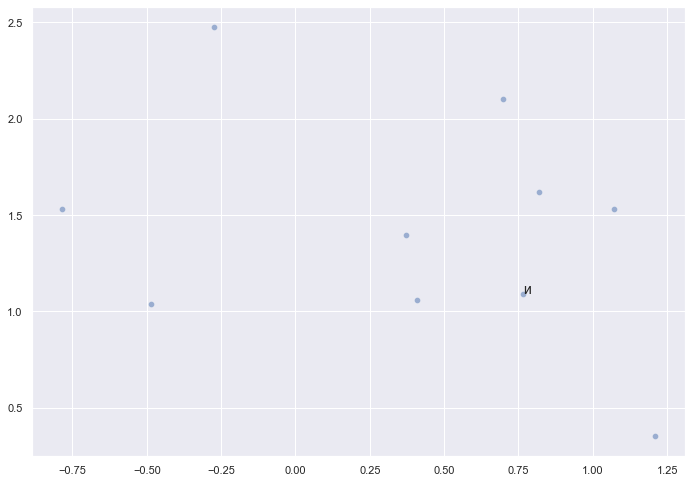

In [88]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

NameError: name 'main_data' is not defined

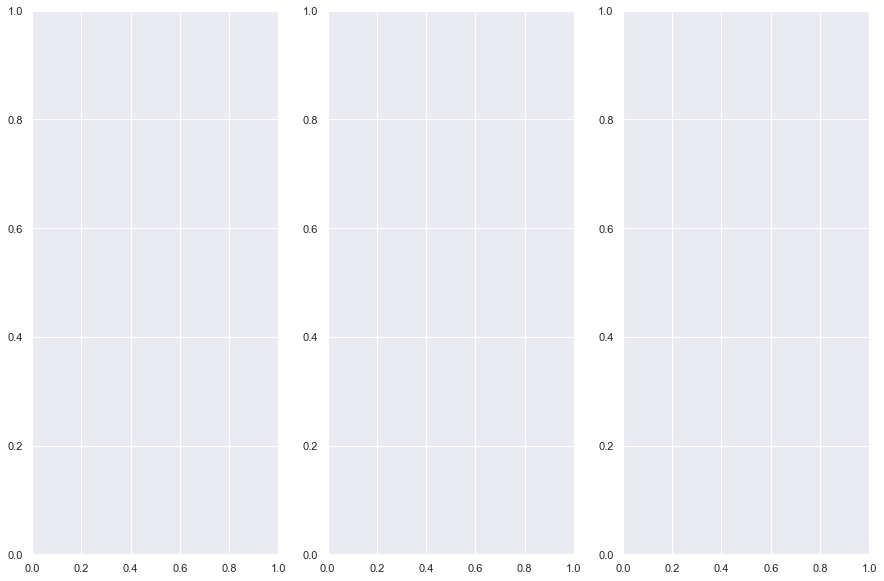

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()

**кластерный анализ**

Итог:
1. Написано что-то про сбор данных и обработку (извлечение сущностей)
2. Начат анализ ланных (предобработка, токенизация в т. ч. на биграммы)
3. Теперь смотрим кластерный анализ (KMeans, Tri-Culster, EM-алгоритм)

Покажу это (все пункты), начало презы -> буду оформлять код получше... Уже много всего надо оформить.

стр. 21; После сегментации будут топики и текстовая аналитика

У нас есть три (см. звонок) важные штуки (позиция, условия труда, специализация) — $X, Y, Z$. 
$(V, W, U)$ s. t. $V \in X, W \in Y, U \in Z$ — то есть, это какие-то элементы наших массивов-столбцов. Вводим переменную $Diff(i)$ со сложной формулой. Для интуиции почитаю ту статью. 

В общем, надо будет весь этот ужас реализовать... Алгоритм 1.

Пока разбираю статью про triclustering.

n-ary relations among several sets of entities

– job banks comprising at least four sets (jobs, job descriptions, job seekers,

это оно!

Про EM-алгоритм: https://habr.com/ru/post/501562/

Про трикластер еще см прещу ту для интерпретации, а дальше разберусь с описанием алгоритма.

Черновик имплементации алгоритма:

1. Мы работаем тут с матрицей. Поэтому построю отображение $r_{i, j, k} = 0/1$. См пример output'а из того ноутбука: вполне адекватно.

Как потом эти три-кластеры интерпретировать? Что если взять объекты из $V, W, U$ любая тройка оттуда будет задавать одно и то же отношение?

**Спросить во время звонка:**

- Презентация

- Project Proposal

- Кластеризация методы